<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-titanic-ml-from-disaster?scriptVersionId=182243991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="background-image: url(https://www.kaggle.com/competitions/3136/images/header); color: #BDD5DD">Titanic - Machine Learning from Disaster

![](https://www.kaggle.com/competitions/3136/images/header)

![](https://gcaptain.com/wp-content/uploads/2016/04/Titanicpaint.jpg)

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">🛳️ Import libraries</span>

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">🧊 Load the training and test set</span>

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">😭 Display histograms of distribution</span>

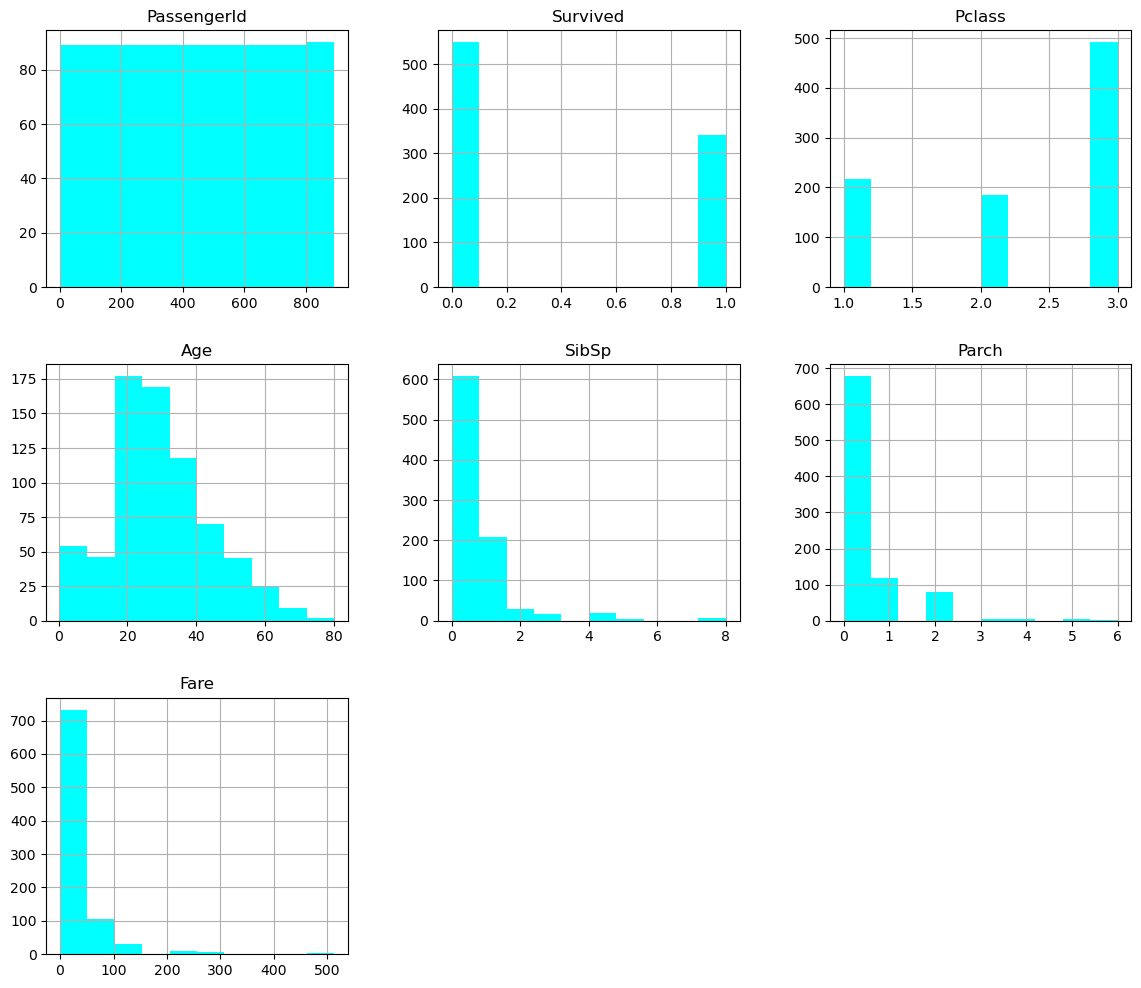

In [5]:
train.hist(figsize=(14, 12), color='aqua');

In [6]:
train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

## <span style="color: red">Women are in two times less than Men

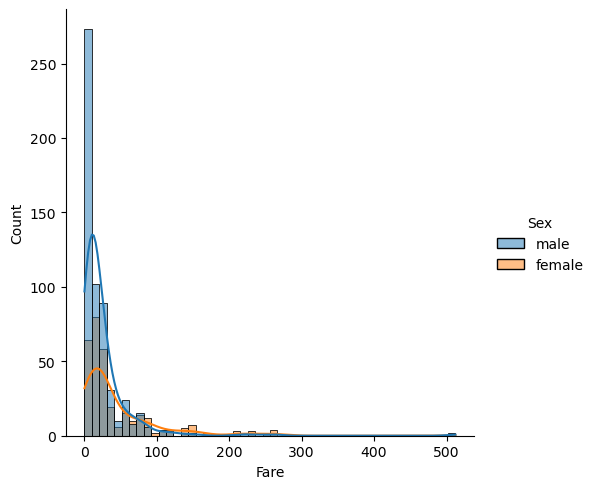

In [7]:
sns.displot(data=train, x='Fare', hue='Sex', bins=50, color='red', kde=True);

## <span style="color: red">Most tickets costed less than 30$

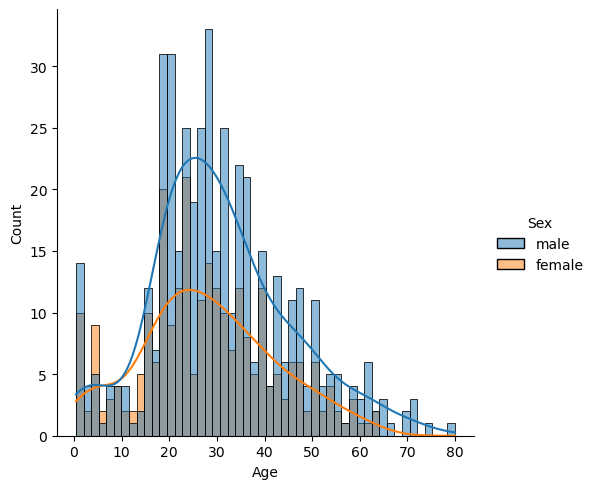

In [8]:
sns.displot(data=train, x='Age', hue='Sex', bins=50, color='orange', kde=True);

## <span style="color: red">Average age for women between 20 and 30, for men between 20 and 40

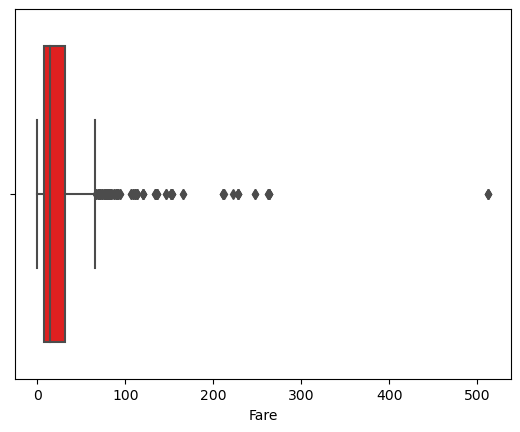

In [9]:
sns.boxplot(data=train, x='Fare', hue='Sex', color='r');

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


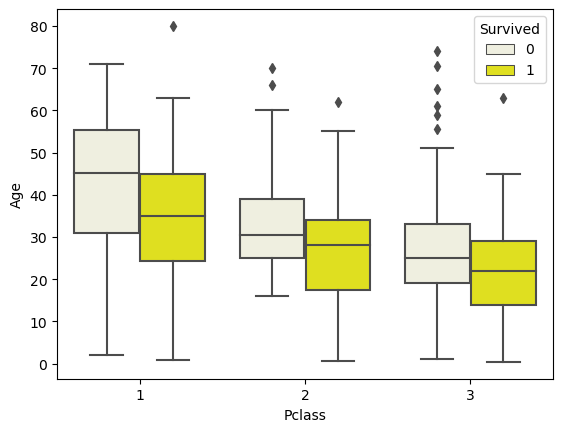

In [11]:
sns.boxplot(data=train, x="Pclass", y="Age", hue="Survived", color='yellow');

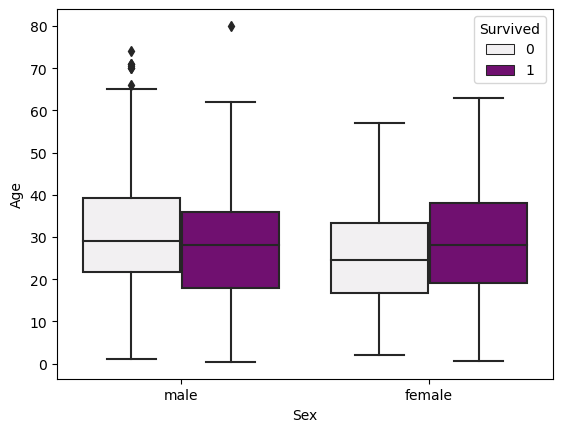

In [12]:
sns.boxplot(data=train, x="Sex", y="Age", hue="Survived", color='purple');

# <span style="color: #03adfc; border-bottom: 6px solid #BDD5DD; background-color: #4d0099;">🚢 consider data gaps and fill them with modal values

In [13]:
# print(train.isna().sum())
# print(test.isna().sum())

train = train.fillna(value=train.mode().iloc[0])
test = test.fillna(value=test.mode().iloc[0])

In [14]:
# check that gaps are filled

test.isna().sum() 

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [15]:
# 4 - leaving only certain features for learning

train = train[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Survived']]
test = test[['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare']]

In [16]:
# 5 - split the training dataset into X and y

X = train.drop(['Survived'], axis=1)
# X = train.loc[:, train.columns != 'Survived']
y = train.Survived

In [17]:
# 6 Let's do a One-Hot transformation with pandas

X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [18]:
# 7 - standardize the values in the samples

sc = StandardScaler()
train_std = sc.fit_transform(X)  # first we train
test_std = sc.transform(test)

In [19]:
# 8 - train the logistic regression model and get a prediction

warnings.filterwarnings('ignore')

clf_log_reg = LogisticRegression()
clf_log_reg.fit(train_std, y)
log_reg_prediction = clf_log_reg.predict(test_std)

# display the first 30 predict values
log_reg_prediction[:30]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0])

![](https://t3.ftcdn.net/jpg/05/70/92/26/360_F_570922643_DPh6V3LhnUgSDDDbpznUvgKeGiF8TgnR.jpg)

In [20]:
# 9 - train the K-nearest neighbors model and get a prediction

clf_KNN = KNeighborsClassifier()
clf_KNN.fit(train_std, y)
KNN_prediction = clf_KNN.predict(test_std)

# display the first 30 forecast values
KNN_prediction[:30]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

In [21]:
# 10 - train the decision tree model and get a prediction

clf_Decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf_Decision_tree.fit(train_std, y)
Decision_tree_prediction = clf_Decision_tree.predict(test_std)

# display the first 30 forecast values
Decision_tree_prediction[:30]

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0])

In [22]:
# 11 - consider decision tree parameters

clf_Decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

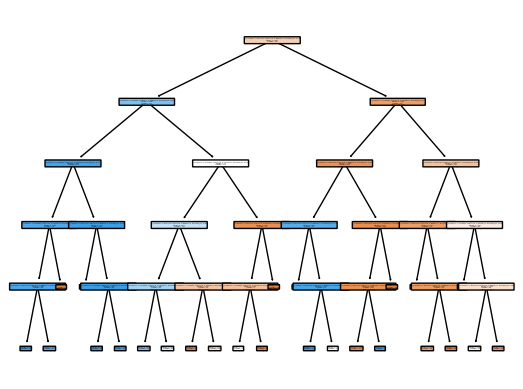

In [23]:
# 12 visualize the decision tree
plot_tree(clf_Decision_tree, feature_names=list(train_std), filled=True, rounded=True);

In [24]:
# 13 - consider the metrics for each of the classification models

# print('Logistic Regression:')
# print(classification_report(y, log_reg_prediction))
# print('K-Nearest Neighbors')
# print(classification_report(y, KNN_prediction))
# print('Decision Tree')
# print(classification_report(y, Decision_tree_prediction))

![](https://i.ytimg.com/vi/MPklvytosy4/hqdefault.jpg)

In [25]:
# # 14 - for the final solution, I used the nearest neighbors method, since it gave me the best result
# # make a prediction on test data

# result = clf_KNN.predict(test_std)
# result

In [26]:
# 14 - Random Forest prediction with hyperparameters tuning
parameters = {
    'criterion': ('gini', 'entropy', 'log_loss'),
    'max_depth': range(101),
    'min_samples_split': range(2, 101, 2),
    'min_samples_leaf': range(2, 101, 2)
}

rf = RandomForestClassifier(n_jobs=-1, random_state=27)
clf = RandomizedSearchCV(
    estimator = rf,
    param_distributions = parameters,
    n_iter = 1000,
    cv = 5,
    verbose = 2
)

# clf.fit(train_std, y)
# clf.best_params_

best_rf = RandomForestClassifier(
    max_depth = 68,
    criterion = 'entropy',
    min_samples_split = 10, 
    min_samples_leaf = 4,
)

best_rf.fit(train_std, y)
result = best_rf.predict(test_std)
result

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [27]:
# 15 - create final submit file-csv

kapturov_titanic = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': result})
kapturov_titanic.to_csv('kapturov_titanic.csv', index=False)

![](https://media.istockphoto.com/id/1177487379/vector/cute-yellow-3d-smiley-face-with-thank-you-quote.jpg?s=612x612&w=0&k=20&c=KxT1Hra-B9vdSstbi4xJ2B-F5je9LfZGU_OO26tR2j0=)